In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import soundfile as sf       # Đọc file an toàn
import librosa               # Tính Pitch an toàn
import numpy as np

# ==============================================================================
# 1. CORE: BỘ TRÍCH XUẤT ĐẶC TRƯNG (HYBRID: TORCH + LIBROSA)
# ==============================================================================
class HandcraftedFeatureExtractor:
    def __init__(self, sample_rate=16000, n_mfcc=40, n_mels=80, n_fft=400, hop_length=160):
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.n_fft = n_fft
        
        # MFCC (Dùng Torchaudio vì nó nhanh và có hỗ trợ GPU)
        self.mfcc_transform = T.MFCC(
            sample_rate=sample_rate, n_mfcc=n_mfcc,
            melkwargs={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "center": False}
        )
        # MFBE (Log Mel-filterbank energies)
        self.mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels, 
            hop_length=hop_length, center=False
        )

    def _get_pitch(self, waveform):
        # --- FIX: Dùng Librosa để tính Pitch (F0) ---
        # Chuyển Tensor sang Numpy (Librosa chỉ nhận Numpy)
        wav_numpy = waveform.squeeze().cpu().numpy()
        
        # Dùng thuật toán pYIN (rất chính xác)
        # hop_length phải khớp với MFCC để có cùng số lượng frame
        # fmin/fmax: Dải tần số giọng nói con người (60Hz - 500Hz)
        try:
            f0, _, _ = librosa.pyin(
                wav_numpy, 
                fmin=60, 
                fmax=500, 
                sr=self.sample_rate, 
                hop_length=self.hop_length,
                frame_length=self.n_fft,
                center=False # Tắt center để khớp với Torchaudio
            )
        except Exception:
            # Fallback nếu file quá ngắn hoặc lỗi
            f0 = np.zeros(1)

        # Thay thế các giá trị NaN (không có tiếng) bằng 0
        f0 = np.nan_to_num(f0)
        
        # Chuyển lại thành Tensor: (1, 1, Time)
        return torch.from_numpy(f0).view(1, 1, -1).float()

    def _align_length(self, feat1, feat2):
        # Cắt bớt phần thừa để 2 đặc trưng có cùng chiều dài Time
        min_len = min(feat1.shape[-1], feat2.shape[-1])
        return feat1[..., :min_len], feat2[..., :min_len]

    def extract(self, waveform, mode="MFBE + Pitch"):
        if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
        
        feature = None
        
        # 1. Tính toán đặc trưng chính (Spectrogram/MFCC)
        if "MFCC" in mode:
            main_feat = self.mfcc_transform(waveform)
        elif "MFBE" in mode:
            main_feat = torch.log(self.mel_transform(waveform) + 1e-6)
        
        # 2. Xử lý ghép nối (Concatenation)
        if mode == "Only MFCC" or mode == "Only MFBE":
            feature = main_feat
            
        elif mode == "Only Pitch":
            feature = self._get_pitch(waveform).squeeze(0)
            
        elif "Pitch" in mode:
            pitch = self._get_pitch(waveform) # (1, 1, T_pitch)
            
            # Đảm bảo main_feat có shape (1, n_mels, T_main)
            if main_feat.dim() == 2: main_feat = main_feat.unsqueeze(0)
            
            # Đồng bộ độ dài (do cách padding của Librosa và Torch có thể lệch 1-2 frame)
            main_feat, pitch = self._align_length(main_feat, pitch)
            
            # Ghép lại: (1, 80, T) + (1, 1, T) -> (1, 81, T)
            feature = torch.cat([main_feat, pitch], dim=1)
        
        # 3. Chuẩn hóa (CMVN)
        if feature is not None:
            mean = feature.mean(dim=-1, keepdim=True)
            std = feature.std(dim=-1, keepdim=True)
            feature = (feature - mean) / (std + 1e-6)
            
        return feature

# ==============================================================================
# 2. DATASET: DÙNG SOUNDFILE (FIX LỖI ĐỌC FILE WINDOWS)
# ==============================================================================
class AudioFolderDataset(Dataset):
    def __init__(self, root_dir, extractor, mode, sample_rate=16000):
        self.root_dir = root_dir
        self.extractor = extractor
        self.mode = mode
        self.sample_rate = sample_rate
        self.file_list = []
        
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.wav', '.flac', '.mp3')):
                    self.file_list.append(os.path.join(root, file))

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        try:
            # Dùng soundfile đọc file (trả về numpy array)
            wav_numpy, sr = sf.read(path)
            
            # Chuyển sang Tensor float32
            waveform = torch.from_numpy(wav_numpy).float()
            
            # Xử lý Channel: (Time, Channels) -> (Channels, Time)
            if waveform.dim() == 1:
                waveform = waveform.unsqueeze(0) # (1, Time)
            else:
                waveform = waveform.t()
                
            # Convert sang Mono (nếu nhiều kênh)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Resample nếu cần
            if sr != self.sample_rate:
                waveform = T.Resample(sr, self.sample_rate)(waveform)

            # Trích xuất đặc trưng
            feat = self.extractor.extract(waveform, mode=self.mode).squeeze(0)
            return feat, path
        
        except Exception as e:
            # In lỗi chi tiết nhưng không dừng chương trình
            print(f"\n[SKIP] Lỗi file {os.path.basename(path)}: {e}")
            return None, None

def collate_fn(batch):
    # Lọc bỏ các mẫu lỗi (None)
    batch = [b for b in batch if b[0] is not None]
    if not batch: return None
    
    feats, paths = zip(*batch)
    
    # Pad để đóng batch (các file âm thanh có độ dài khác nhau)
    max_len = max([f.shape[-1] for f in feats])
    padded_feats = [torch.nn.functional.pad(f, (0, max_len - f.shape[-1])) for f in feats]
    
    return torch.stack(padded_feats), paths

# ==============================================================================
# 3. EXECUTION
# ==============================================================================
if __name__ == "__main__":
    # --- Cài đặt tham số ---
    INPUT_PATH = r"D:\Study\7-SP26\DATxSLP\Data_after_cut\test_output"
    OUTPUT_PATH = r"D:\Study\7-SP26\DATxSLP\Data_after_extract_feature"
    EXTRACT_MODE = "MFBE + Pitch"
    
    # Check thiết bị
    device = torch.device("cpu")
    print(f"Device: {device}")

    extractor = HandcraftedFeatureExtractor()
    dataset = AudioFolderDataset(INPUT_PATH, extractor, EXTRACT_MODE)
    
    # num_workers=0 để tránh lỗi đa luồng trên Windows
    loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

    print(f"Bắt đầu trích xuất: {EXTRACT_MODE}")
    print(f"Tổng số file tìm thấy: {len(dataset)}")

    for batch in tqdm(loader):
        if batch is None: continue
        feats, paths = batch
        feats = feats.to(device)

        for i in range(len(paths)):
            rel_path = os.path.relpath(paths[i], INPUT_PATH)
            save_path = os.path.join(OUTPUT_PATH, os.path.splitext(rel_path)[0] + ".pt")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            # Lưu file .pt
            torch.save(feats[i].cpu(), save_path)

    print(f"\nHoàn thành! Kiểm tra tại: {OUTPUT_PATH}")

Device: cpu
Bắt đầu trích xuất: MFBE + Pitch
Tổng số file tìm thấy: 348


 27%|██▋       | 6/22 [03:09<08:21, 31.34s/it]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13984\4042407708.py:97: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  std = feature.std(dim=-1, keepdim=True)
 32%|███▏      | 7/22 [03:28<06:48, 27.26s/it]

In [7]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import soundfile as sf
import librosa
import numpy as np

# ==============================================================================
# 1. GPU ENABLED EXTRACTOR
# ==============================================================================
class HandcraftedFeatureExtractor:
    def __init__(self, device, sample_rate=16000, n_mfcc=40, n_mels=80, n_fft=400, hop_length=160):
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.device = device # Lưu thiết bị (cuda/cpu)

        # --- Đưa các bộ biến đổi lên GPU ngay khi khởi tạo ---
        self.mfcc_transform = T.MFCC(
            sample_rate=sample_rate, n_mfcc=n_mfcc,
            melkwargs={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "center": False}
        ).to(self.device)

        self.mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels, 
            hop_length=hop_length, center=False
        ).to(self.device)

    def _get_pitch_cpu(self, waveform_cpu):
        # Hàm này chạy trên CPU vì Librosa không hỗ trợ GPU
        wav_numpy = waveform_cpu.squeeze().numpy()
        
        try:
            # Dùng piptrack nhanh hơn pyin một chút, hoặc giữ pyin nếu cần chính xác cao
            # Ở đây giữ pyin để đảm bảo chất lượng
            f0, _, _ = librosa.pyin(
                wav_numpy, 
                fmin=60, fmax=500, sr=self.sample_rate, 
                hop_length=self.hop_length, frame_length=self.n_fft, center=False
            )
        except:
            f0 = np.zeros(1)

        f0 = np.nan_to_num(f0)
        # Trả về Tensor (chưa cần đẩy lên GPU vội)
        return torch.from_numpy(f0).view(1, 1, -1).float()

    def _align_length(self, feat1, feat2):
        min_len = min(feat1.shape[-1], feat2.shape[-1])
        return feat1[..., :min_len], feat2[..., :min_len]

    def extract(self, waveform, mode="MFBE + Pitch"):
        # waveform đầu vào đang ở CPU (từ DataLoader)
        
        feature = None
        
        # 1. Xử lý phần GPU (Nặng nhất - MFCC/Mel)
        # Đẩy waveform lên GPU để tính toán
        waveform_gpu = waveform.to(self.device)
        if waveform_gpu.dim() == 1: waveform_gpu = waveform_gpu.unsqueeze(0)

        main_feat = None
        if "MFCC" in mode:
            main_feat = self.mfcc_transform(waveform_gpu)
        elif "MFBE" in mode:
            main_feat = torch.log(self.mel_transform(waveform_gpu) + 1e-6)
        
        # 2. Xử lý phần Pitch (Nếu cần) - Buộc phải chạy CPU
        if "Pitch" in mode or mode == "Only Pitch":
            # Dùng bản copy ở CPU để đưa vào Librosa
            pitch_cpu = self._get_pitch_cpu(waveform) 
            # Sau khi tính xong, đẩy kết quả lên GPU để ghép
            pitch = pitch_cpu.to(self.device) 

        # 3. Ghép nối (trên GPU)
        if mode == "Only MFCC" or mode == "Only MFBE":
            feature = main_feat
        elif mode == "Only Pitch":
            feature = pitch.squeeze(0)
        elif "Pitch" in mode:
            if main_feat.dim() == 2: main_feat = main_feat.unsqueeze(0)
            main_feat, pitch = self._align_length(main_feat, pitch)
            feature = torch.cat([main_feat, pitch], dim=1)
        
        # 4. CMVN (Normalization) trên GPU
        if feature is not None:
            mean = feature.mean(dim=-1, keepdim=True)
            std = feature.std(dim=-1, keepdim=True)
            feature = (feature - mean) / (std + 1e-6)
            
        return feature

# ==============================================================================
# 2. DATASET (GIỮ NGUYÊN - DÙNG SOUNDFILE)
# ==============================================================================
class AudioFolderDataset(Dataset):
    def __init__(self, root_dir, extractor, mode, sample_rate=16000):
        self.root_dir = root_dir
        self.extractor = extractor
        self.mode = mode
        self.sample_rate = sample_rate
        self.file_list = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.wav', '.flac', '.mp3')):
                    self.file_list.append(os.path.join(root, file))

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        try:
            wav_numpy, sr = sf.read(path)
            waveform = torch.from_numpy(wav_numpy).float()
            if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
            else: waveform = waveform.t()
            if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
            if sr != self.sample_rate: waveform = T.Resample(sr, self.sample_rate)(waveform)

            # LƯU Ý: Ở đây ta giữ waveform ở CPU, chỉ đưa vào extractor mới đẩy lên GPU
            # để tiết kiệm VRAM khi DataLoader load nhiều worker (nếu dùng Linux)
            
            # Gọi hàm extract trực tiếp ở đây để xử lý từng file
            feat = self.extractor.extract(waveform, mode=self.mode).squeeze(0)
            
            # Quan trọng: Đưa feature về CPU trước khi trả về để DataLoader gom batch
            # (Tránh lỗi bộ nhớ GPU khi gom batch quá lớn)
            return feat.cpu(), path 
        except Exception as e:
            return None, None

def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch: return None
    feats, paths = zip(*batch)
    max_len = max([f.shape[-1] for f in feats])
    padded_feats = [torch.nn.functional.pad(f, (0, max_len - f.shape[-1])) for f in feats]
    return torch.stack(padded_feats), paths

# ==============================================================================
# 3. EXECUTION
# ==============================================================================
if __name__ == "__main__":
    # --- Cài đặt tham số ---
    INPUT_PATH = r"D:\Study\7-SP26\DATxSLP\Data_after_cut\test_output"
    OUTPUT_PATH = r"D:\Study\7-SP26\DATxSLP\Data_after_extract_feature\MFBE"
    EXTRACT_MODE = "Only Pitch"  #Only MFCC, Only MFBE, Only Pitch, MFCC + Pitch, MFBE + Pitch.
    
    # --- SETUP GPU ---
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"🔥 Đang chạy trên GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠️ Không tìm thấy GPU, đang chạy trên CPU.")

    # Truyền device vào Extractor
    extractor = HandcraftedFeatureExtractor(device=device)
    dataset = AudioFolderDataset(INPUT_PATH, extractor, EXTRACT_MODE)
    
    # Lưu ý: Trên Windows, num_workers vẫn nên để = 0 để tránh lỗi
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

    print(f"Bắt đầu trích xuất: {EXTRACT_MODE}")
    for batch in tqdm(loader):
        if batch is None: continue
        feats, paths = batch
        
        # feats lúc này đang ở CPU (do collate_fn), ta không cần đẩy lên GPU nữa 
        # vì việc trích xuất đã xong trong Dataset rồi. Giờ chỉ việc lưu.

        for i in range(len(paths)):
            rel_path = os.path.relpath(paths[i], INPUT_PATH)
            save_path = os.path.join(OUTPUT_PATH, os.path.splitext(rel_path)[0] + ".pt")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(feats[i], save_path)

    print(f"\nHoàn thành! Kiểm tra tại: {OUTPUT_PATH}")

🔥 Đang chạy trên GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Bắt đầu trích xuất: Only Pitch


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [09:48<00:00, 53.51s/it]


Hoàn thành! Kiểm tra tại: D:\Study\7-SP26\DATxSLP\Data_after_extract_feature\MFBE


🔍 Tìm thấy 348 file. Đang kiểm tra ngẫu nhiên 3 file...

==================== FILE 1 ====================
📂 File: id00005_test-00000-of-00038_69_seg_015.pt
📐 Shape: torch.Size([40, 1074])
⚠️ Có NaN: False | Có Inf: False
📊 Min: -4.5589 | Max: 4.7046 | Mean: 0.0000
❌ Lỗi khi đọc file này: index 0 is out of bounds for axis 0 with size 0
==================== FILE 2 ====================
📂 File: id00005_test-00000-of-00038_63_seg_013.pt
📐 Shape: torch.Size([40, 2312])
⚠️ Có NaN: False | Có Inf: False
📊 Min: -3.9093 | Max: 3.9651 | Mean: 0.0000
❌ Lỗi khi đọc file này: index 0 is out of bounds for axis 0 with size 0
==================== FILE 3 ====================
📂 File: id00005_test-00000-of-00038_18_seg_011.pt
📐 Shape: torch.Size([40, 648])
⚠️ Có NaN: False | Có Inf: False
📊 Min: -3.8220 | Max: 3.8187 | Mean: 0.0000
❌ Lỗi khi đọc file này: index 0 is out of bounds for axis 0 with size 0


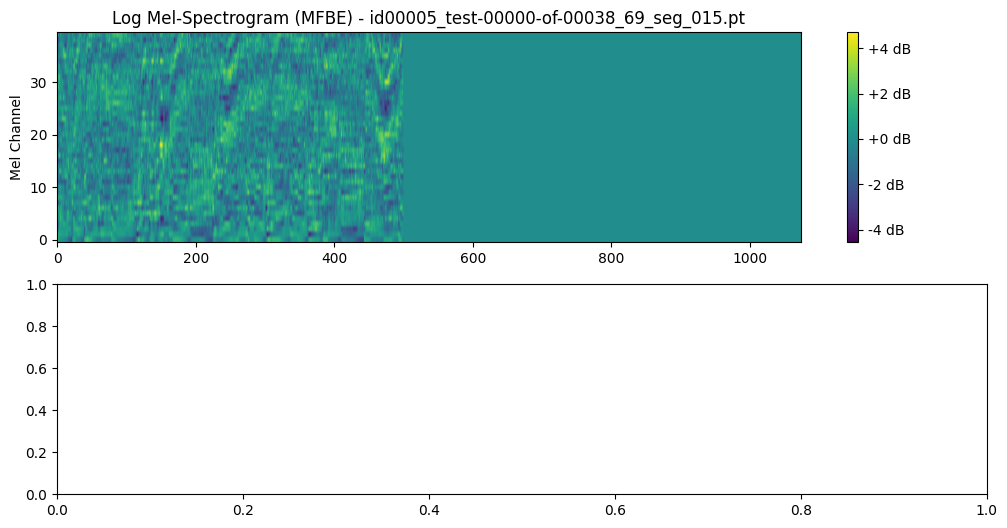

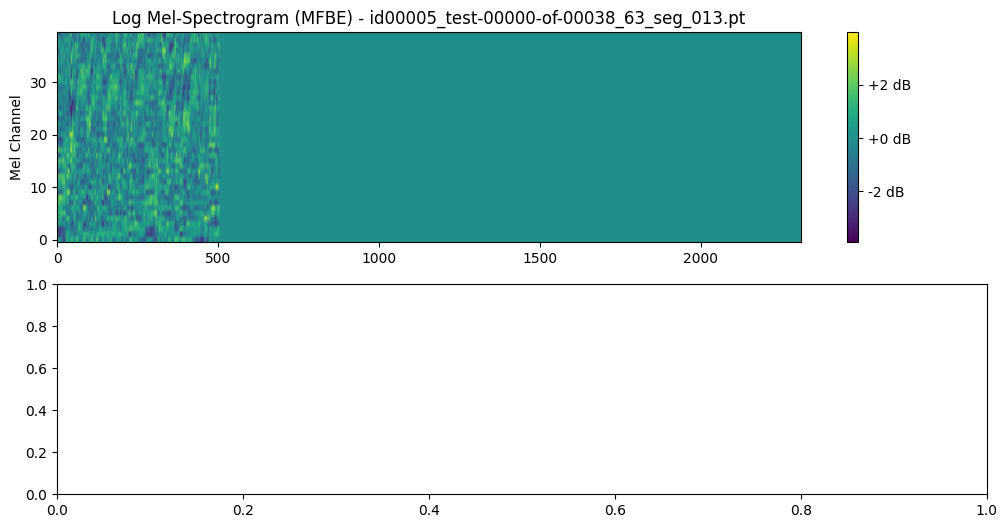

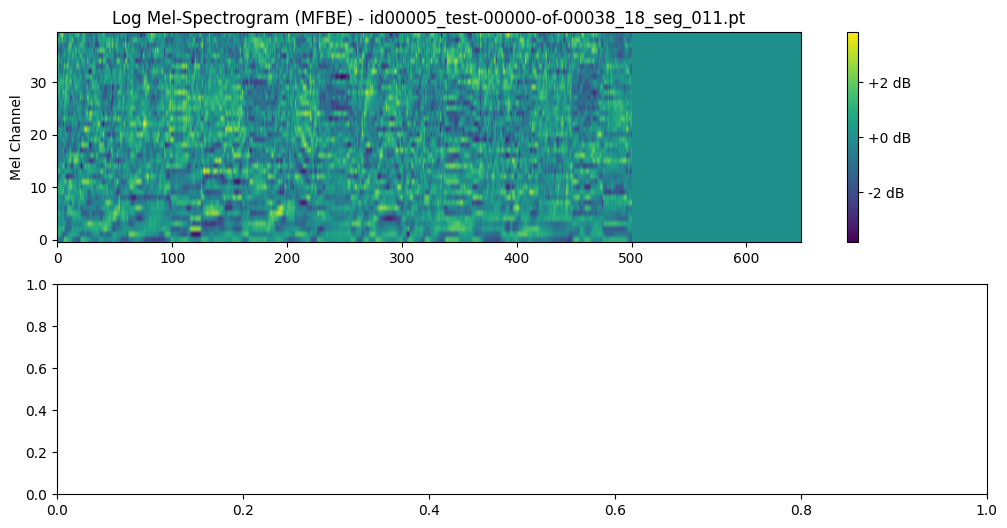

In [4]:
import torch
import matplotlib.pyplot as plt
import os
import glob
import random

def check_and_visualize(output_folder, num_samples=3):
    # Tìm tất cả file .pt trong folder output
    files = list(glob.glob(os.path.join(output_folder, "**/*.pt"), recursive=True))
    
    if not files:
        print("❌ Không tìm thấy file .pt nào trong thư mục!")
        return

    print(f"🔍 Tìm thấy {len(files)} file. Đang kiểm tra ngẫu nhiên {num_samples} file...\n")
    
    # Chọn ngẫu nhiên vài file để check
    samples = random.sample(files, min(len(files), num_samples))
    
    for i, file_path in enumerate(samples):
        print(f"{'='*20} FILE {i+1} {'='*20}")
        print(f"📂 File: {os.path.basename(file_path)}")
        
        try:
            # Load tensor
            feat = torch.load(file_path)
            
            # 1. Kiểm tra Shape
            print(f"📐 Shape: {feat.shape}")
            # Shape chuẩn kỳ vọng: (1, 81, Time) với 81 = 80 Mel + 1 Pitch
            
            # 2. Kiểm tra giá trị
            has_nan = torch.isnan(feat).any().item()
            has_inf = torch.isinf(feat).any().item()
            print(f"⚠️ Có NaN: {has_nan} | Có Inf: {has_inf}")
            print(f"📊 Min: {feat.min():.4f} | Max: {feat.max():.4f} | Mean: {feat.mean():.4f}")
            
            # 3. Vẽ hình (Visualization)
            feat_np = feat.squeeze(0).numpy() # (81, Time)
            
            # Tách phần MFBE (80 dòng đầu) và Pitch (dòng cuối)
            mfbe = feat_np[:80, :]
            pitch = feat_np[80:, :]
            
            plt.figure(figsize=(12, 6))
            
            # Vẽ MFBE
            plt.subplot(2, 1, 1)
            plt.imshow(mfbe, aspect='auto', origin='lower', cmap='viridis')
            plt.title(f"Log Mel-Spectrogram (MFBE) - {os.path.basename(file_path)}")
            plt.ylabel("Mel Channel")
            plt.colorbar(format='%+2.0f dB')
            
            # Vẽ Pitch
            plt.subplot(2, 1, 2)
            plt.plot(pitch[0], color='red', linewidth=1.5)
            plt.title("Pitch (F0) Feature (Normalized)")
            plt.ylabel("Value")
            plt.xlabel("Time Frames")
            plt.xlim(0, pitch.shape[1])
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"❌ Lỗi khi đọc file này: {e}")

# --- CHẠY KIỂM TRA ---
OUTPUT_PATH = r"D:\Study\7-SP26\DATxSLP\Data_after_extract_feature\MFCC" # Đường dẫn folder chứa file .pt của bạn
check_and_visualize(OUTPUT_PATH)

In [12]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


# =========================
# INSPECT FEATURE
# =========================
def inspect_tensor(x, name="feature"):
    print(f"\n🔹 {name}")
    print(f"  Type      : {type(x)}")

    if isinstance(x, torch.Tensor):
        x = x.cpu()
        print(f"  Shape     : {tuple(x.shape)}")
        print(f"  Dtype     : {x.dtype}")
        print(f"  Min / Max : {x.min().item():.4f} / {x.max().item():.4f}")
        print(f"  Mean / Std: {x.mean().item():.4f} / {x.std().item():.4f}")
        print(f"  NaN       : {torch.isnan(x).any().item()}")
        print(f"  Inf       : {torch.isinf(x).any().item()}")
        print(f"  Sample    : {x.flatten()[:8]}")

    else:
        print("  ⚠️ Unsupported type")


# =========================
# PLOT FEATURE
# =========================
def plot_feature(x, title="Feature"):
    """
    x: torch.Tensor
    """
    x = x.cpu().numpy()

    plt.figure(figsize=(8, 4))

    # Pitch: (T,) or (T,1)
    if x.ndim == 1 or (x.ndim == 2 and x.shape[1] == 1):
        plt.plot(x.squeeze())
        plt.ylabel("Pitch")
        plt.xlabel("Frame")

    # MFCC / MFBE: (T, D)
    elif x.ndim == 2:
        plt.imshow(
            x.T,
            aspect="auto",
            origin="lower"
        )
        plt.colorbar()
        plt.ylabel("Feature dim")
        plt.xlabel("Frame")

    else:
        print(f"⚠️ Cannot plot shape {x.shape}")
        return

    plt.title(title)
    plt.tight_layout()
    plt.show()


# =========================
# INSPECT SINGLE .pt FILE
# =========================
def inspect_pt_file(pt_path, plot=False):
    print("=" * 70)
    print(f"📂 File: {pt_path}")

    data = torch.load(pt_path, map_location="cpu")
    print(f"📦 Root type: {type(data)}")

    # Case 1: single feature
    if isinstance(data, torch.Tensor):
        inspect_tensor(data, "Single Feature")
        if plot:
            plot_feature(data, title=os.path.basename(pt_path))

    # Case 2: multiple features (MFCC + Pitch, MFBE + Pitch)
    elif isinstance(data, dict):
        print(f"🔑 Keys: {list(data.keys())}")
        for k, v in data.items():
            inspect_tensor(v, f"Feature [{k}]")
            if plot:
                plot_feature(v, title=f"{os.path.basename(pt_path)} - {k}")

    else:
        print("❌ Unsupported .pt format")

    print("=" * 70)


# =========================
# READ FOLDER
# =========================
def inspect_feature_folder(
    folder_path,
    max_files=3,
    plot=True
):
    """
    folder_path: path to feature folder (MFCC / MFBE / Pitch / ...)
    max_files  : limit number of files to inspect
    plot       : whether to draw spectrogram
    """
    print(f"\n📁 Inspecting folder: {folder_path}")

    pt_files = sorted([
        f for f in os.listdir(folder_path)
        if f.endswith(".pt")
    ])

    print(f"📊 Found {len(pt_files)} .pt files")

    for i, fname in enumerate(pt_files[:max_files]):
        pt_path = os.path.join(folder_path, fname)
        inspect_pt_file(pt_path, plot=plot)


# =========================
# MAIN
# =========================
if __name__ == "__main__":

    # 🔧 CHANGE THIS
    FEATURE_FOLDER = r"D:\Study\7-SP26\DATxSLP\Data_after_extract_feature\Pitch"

    inspect_feature_folder(
        folder_path=FEATURE_FOLDER,
        max_files=3,   # inspect first N files
        plot=True      # draw spectrogram / pitch curve
    )



📁 Inspecting folder: D:\Study\7-SP26\DATxSLP\Data_after_extract_feature\Pitch
📊 Found 0 .pt files
